In [3]:
##here I recreate the entire original algorithm as a set of customizable functions

### Genetic algorithm to fit a regression line of the form y=ax+b to a 2-variable dataset

import random
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

# load the data
my_data_file = 'temp_data.npy'
data = np.load(my_data_file)

x = []
y = []

for row in data:
    x.append(row[0])
    y.append(row[1])

# functions

#A generates the initial population of chromosomes, which each represents the slope and y-intercept of a regression line.
#It generates a gene pool pool of potential values for the coefficients using np.linspace (returns a list of a set number of values between two points).
#It then sets the dimensions of the population array, which has one row for each chromosome and a column for each gene.
#The population is filled by randomly choosing values from the gene pool to create a new array of the previously defined dimensions.
#This array is then outputted and used in the initialization of the main program.
def A(initial_pop_size, chromosome_length):
    gene_pool = np.linspace(-1,80,num = 5000)
    dimensions = (initial_pop_size, chromosome_length)
    return np.random.choice(gene_pool, size=dimensions, replace=False)

#B measures how fit each chromosome is by calculating the average error between the regression line it encodes and the actual y values.
#It iterates through each data point and calculates the expected y value using the inputted coefficients encoded in the chromosome and the x value.
#For each point, it finds the residual by subtracting the expected y value from the actual value.
#This value is then squared and added to the total error sum of squares so far. 
#After each point has been checked, the sum of squares is divided by the amount of data points to calculate the average, which it outputs.
def B(coefficients):
    k = len(data)
    tot = 0
    for j in range(k):
        y = coefficients[0] * data[j,0] + coefficients[1]
        res = data[j,1] - y
        tot += res**2
    return tot/k

#C creates a fitness vector that pairs each chromosome with its fitness, as determined by function B.
#It iterates through each index of the current population, which each correspond to a chromosome.
#For every index, a numpy array containing it and its average error (calculated by B) is appended to a list.
#The list is then converted to a numpy array and outputted.
def C(current_pop):
    fitlist = []
    for x in range(len(current_pop)):
        fitlist.append(np.array([x,B(current_pop[x])]))
    return np.array(fitlist)

#D selects a chromosome for survival based off both random choice and fitness, as calculated by B.
#It randomly chooses 25 (the number of survivors / 2) chromosomes, identified by their index on the fitness vector generated by C.
#It then selects the most fit chromosome from this randomly generated list.
#It identifies the index of this single chromosome and then locates it in the current population.
#The chromosome's coefficient values (as opposed to its index) are outputted.
def D(fitness_vector, num_survivors, current_pop):
    random_selection = np.random.choice(range(len(fitness_vector)), num_survivors//2, replace=False)
   # print(fitness_vector[random_selection,1])
    best = np.argmin(fitness_vector[random_selection,1])
    best_index = random_selection[best]
 #print("index", best_index, "vector", fitness_vector[best_index][0])
    return current_pop[int(fitness_vector[best_index][0])]    

#E represents breeding and crossover to fill the new population with the offspring of the survivors selected by D.
#It creates an empty list to represent the new chromosomes that need to be created to fill the new population.
#It then iterates through the columns, which represent the slope and y-intercept coefficients.
#Each column is replaced with the corresponding survivors column, repeated 4 times (to fill the entire column).
#The order of the duplicated coefficients is then randomly rearranged, and the numpy array is outputted.
def E(new_population, survivors, chromosome_length):
    duplicate_size = len(new_population) - len(survivors)
    duplicate_survivors = np.zeros((duplicate_size, chromosome_length))
    for x in range(chromosome_length): # for each column in the survivor array
        duplicate_survivors[:, x] = np.repeat(survivors[:, x], (duplicate_size / len(survivors)), axis=0)
        duplicate_survivors[:, x] = np.random.permutation(duplicate_survivors[:, x])
    return duplicate_survivors

#F should represent mutation by randomly changing chromosomes at the predetermined mutation rate. 
#This improves the likelihood of finding the best solution by randomly altering chromosomes, thereby covering more of the 
#solution space and preventing the algorithm from getting stuck in a local optimum.
#My code calculates the total number of genes in the population, then finds how many should be mutated using the mutation rate.
#It then randomly selects genes to be mutated (from a list of 500) and iterates through each.
#It multiplies each gene by a mutator, from 0-1, and then replaces the original with the new version.
#The array with mutated genes is outputted.
def F(new_population, mutation_rate): 
    genes = len(new_population) * len(new_population[0])
    num_mutated = int(genes * mutation_rate)
    genes_mutated = np.random.choice(genes, num_mutated, replace=False)
    for g in genes_mutated:
        mutator = random.random()
        if g > (len(new_population) - 1):
            mutant = new_population[g-len(new_population)][1]
            mutant = mutant * mutator
            new_population[g-len(new_population)][1] = mutant
        else: 
            mutant = new_population[g][0]
            mutant = mutant * mutator
            new_population[g][0] = mutant
    return new_population

#G prints the original data along with the trendline the algorithm found.
#It calculates the trendline by finding the expected y value based off the current best coefficients.
def G():
    trendline = []
    slope = float(best_solution[0])
    yint = float(best_solution[1])
    for i in x:
        trendy = slope * i + yint
        trendline.append(trendy)

    plt.plot(x, y, 'ro', x, trendline, 'b-')
    plt.show()

########################################################################
# Start of main program

initial_pop_size = 100
chromosome_length = 2

def optreg(mutation_rate, num_generations, num_survivors):
    #These lines initialize the program by creating the original population of 100 chromosomes using A and a new population 
    #of 250 chromosomes, currently filled with zeroes.
    current_pop = A(initial_pop_size, chromosome_length)
    new_population = np.zeros((num_survivors * 5, chromosome_length))
    #Initializes a list to store the error of the best solution, calculated by B, for every generation.
    errors = []
    # main loop
    #A new population is created for each generation (10 in this case).
    for i in range(num_generations):

        #C is called to create a list matching each chromosome with its fitness, calculated by B.
        fitness_vector = C(current_pop)
        #An empty array (of just 0s) is created to store the chromosomes that will survive to go in to the next generation (50 in this case).
        survivors = np.zeros((num_survivors, chromosome_length))
        #This loop iterates through the survivors array, filling each index with an existing chromosome chosen by D.
        for n in range(len(survivors)):
            survivors[n] = D(fitness_vector, num_survivors, current_pop)
        #The survivors are inserted into the new population.
        new_population[:len(survivors)] = survivors
        #The rest of the new population is filled by duplicating the survivors using E.
        new_population[len(survivors):] = E(new_population, survivors, chromosome_length)

        #The chromosomes in the new population are mutated using F.
        new_population = F(new_population, mutation_rate)

        #These lines reinitialize the code for the next generation.
        #The population that was just generated becomes the current population.
        current_pop = new_population
        #A new empty population is created to be filled by a new generation of chromosomes.
        new_population = np.zeros((num_survivors * 5, chromosome_length))

        #I modified the code to print the current best solution, error, and graph on every generation to see how it improves over iterations.
        #Calculates the fitness of each current chromosome.
        fitness_vector = C(current_pop)
        #Determines the current best solution by finding which chromosome has the lowest error (given by argmin).
        best_solution = current_pop[np.argmin(fitness_vector[:,1])]
        #Appends the error of the current best solution to the accumulator list.
        errors.append(B(best_solution))
        
    return best_solution, errors

The best solution is: [0.5691155935983945, 4, 38]


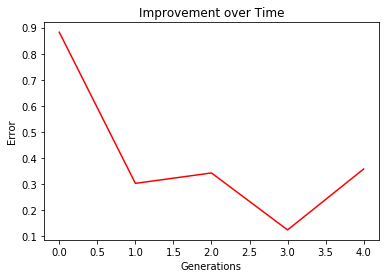

In [8]:
#This meta-optimization program has the same structure as the genetic separation line algorithm I wrote.
#It attempts to find the set of parameters that will produce the most improvement in the original genetic regression algorithm

import random

#parameters
pop = 10 #must be multiple of 2 for the makegen population to function; chromosomes need to be paired off
mutrate = 0.05 
numgen = 5  
chromlen = 3 #represents the mutation rate, generation number, and number of survivors for an original algorithm

#calculates the fitness of a chromosome by measuring how much the optimization algorithm it is used on improves in error
def metaopterr(errors):
    
    enderr = errors[(len(errors) - 1)]
    initerr = errors[0]
    
    #calculates the improvement in error and divides it by the initial error to make fitness less dependent on the initial, 
    # randomly generated population
    #it is important to note that this value must be maximized, not minimized, to find the best parameters
    return (initerr - enderr) / initerr

#identical the separation line makepop function, but modified for three genes instead of 2
def makepop():
    mutgenepool = []
    gengenepool = []
    survgenepool = []
    
    for i in range(100):
        mutgenepool.append(i/100)
    for i in range(1, 11):
        gengenepool.append(i)
    for i in range(2, 101):
        survgenepool.append(i)

    chromosomes = []
    
    for i in range(pop):
        newchrom = []
        newchrom.append(random.choice(mutgenepool))
        newchrom.append(random.choice(gengenepool))
        newchrom.append(random.choice(survgenepool))

        chromosomes.append(newchrom)

    return chromosomes

#determines the fitness of each chromosome by calculating its error using metaopterr and adding it to a list
def findfit(poplist):
    
    fitlist = []
    
    for i in poplist:

        gene1 = i[0]
        gene2 = i[1]
        gene3 = i[2]
       
        errors = optreg(gene1, gene2, gene3)[1]
        
        fitness = metaopterr(errors) 
        
        fitlist.append([fitness, i])
    
    return fitlist
        
#produces a new chromosome from two parents using one of two reproduction methods
def skoodilypooping(mom, dad):
    
    #initializes list to store new chromosome
    baby = []
    
    #randomly selects a binary value to determine which type of reproduction to use
    type = random.choice([0, 1])
    
    #the first reproduction type creates a child by averaging the values for each parent gene
    if type == 0:       
        for g in range(chromlen):        

            if g != 0:
                newgene = int((mom[g] + dad[g]) / 2)
            else:
                newgene = (mom[g] + dad[g]) / 2

            baby.append(newgene)
     
    #the second reproduction type creates a child by copying one gene from each parent
    else:
        baby.append(mom[0])
        baby.append(dad[1])
        baby.append(mom[2])
            
    #returns the new chromosome         
    return baby

#generates a new generation of chromosomes
def makegen():
    
    #copies fitness list so values can be removed (used in breeding the most fit parents below) without altering the original
    fitlist = fitnesslist[:]
    
    #initializes list to store the new population
    newpop = []
    
    #half of the new population is produced from the most fit existing chromosomes
    for i in range(int(pop / 4)):
        
        #the two minimum values are found and then removed so that the code can run multiple times without using the same values
        mom = max(fitlist)[1]
        fitlist.remove(max(fitlist))
        dad = max(fitlist)[1]
        fitlist.remove(max(fitlist))
        
        #a child is produced from the two most fit chromosomes using the breeding function and added to the new population
        baby = skoodilypooping(mom, dad)
        newpop.append(baby)
        
        #the most fit chromosomes are preserved in the new population
        newpop.append(mom)
    
    #the other half of the population is produced from randomly selected chromosomes
    for i in range(int(pop / 2)):
        #the orignial fitnesslist, which was not altered by the previous loop
        mom = random.choice(fitnesslist)[1]
        dad = random.choice(fitnesslist)[1]
        
        #a child is produced from the two chromosomes and added to the new population
        baby = skoodilypooping(mom, dad)
        newpop.append(baby)
    
    #the new population of chromosomes is outputted
    return newpop  

#randomly mutates chromosomes in the new population
def mutation():
    
    #iterates through each chromosome
    for c in newpop:
        
        #tests to see if the chromosome should be mutated using the mutation rate and random selection
        #converts the mutation rate to an integer
        newmut = int(mutrate * 100)
        #selects a random integer between 0 and 100
        mut = random.choice(range(100))   
        #if the random value is less than the converted mutation rate, it is mutated
        #this ensures that each chromosome has the correct probability of being mutated
        if mut < newmut:
            
            #initializes list to store mutated chromosome
            newchrom = []
            
            for g in range(len(c)):       
                gene = c[g]
                
                #because generation number and survivor number must be integers, they are mutated by multiplying themselves by a 
                # a random number between -1 and 1, which is then added to them and converted to an integer
                if g != 0:
                    mutator = gene * random.uniform(-1, 1)
                    gene = gene + mutator
                    gene = int(gene)
                    if gene < 1:
                        gene = 1
                #the mutation rate can be a decimal, so it is computed in the same way as line coefficients
                else:
                    mutator = random.random()
                    gene = gene * mutator
                    
                newchrom.append(gene)
        
            newpop.insert(newpop.index(c), newchrom)
            newpop.remove(c)
        
    return newpop
            
    
###############################################   MAIN PROGRAM    ##############################################################

#creates an initial population
currentpop = makepop()

#initializes a list to store the error of the most fit chromosome for every generation
errlist = []

#iterates through each generation
for i in range(numgen):
    
    #calculates the fitness of each current chromosome
    fitnesslist = findfit(currentpop)
    
    #generates and then mutates a new population
    newpop = makegen()   
    newpop = mutation()
    
    #calculates the fitness of each new chromosome
    fitnesslist = findfit(newpop)
    
    #finds the chromosome with the smallest error and calculates its error, which is added to the accumulator list
    bestchrom = max(fitnesslist)[1]
    besterr = metaopterr(optreg(bestchrom[0], bestchrom[1], bestchrom[2])[1])
    errlist.append(besterr)
    
    #assigns the new population to the currentpop variable for the next generation
    currentpop = newpop

#prints the best solution and a graph showing how the error improved with each generation
print("The best solution is:", bestchrom)
plt.plot(range(numgen), errlist, 'r-')
plt.xlabel("Generations")
plt.ylabel("Error")
plt.title("Improvement over Time")
plt.show()